In [1]:
# read data to initialize model starting with input text file
input_file_name = 'run_example.txt' ### IMPORTANT, file name that will be used for the run
myTP = 'adiabatic' ### IMPORTANT, must set before run: choices are adiabatic or isothermal

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import time

home = os.getcwd()
os.chdir(home+'/CoreCode')

import mylibrary as mylib
import mylibrary2 as mylib2

In [3]:
master_time_start = time.time()

# read data to initialize model starting with input text file
runparams = mylib2.read_input(input_file_name,home)
# read planetary parameters
os.chdir(home+'/data/planetparams')
sysparams = mylib2.read_parameterdata(runparams)
sysparams['geof'] = runparams['geof']
os.chdir(home+'/data/mycomps')
# read composition data
runparams['names'],sysparams['Pv_coefs'] = mylib2.read_Pv('BSE.txt',runparams)
# read RT data
if runparams['RT_factor'] == 0:
    sysparams['Tspace'],sysparams['molespace'],sysparams['RCtable'],sysparams['stelabsvec'] = np.random.rand(5,5),np.random.rand(5,5),np.random.rand(5,5),np.random.rand(5,5)
else:
    os.chdir(home+'/data/RTdata/{s}'.format(s=runparams['planet_name']))
    sysparams['Tspace'],sysparams['molespace'],sysparams['RCtable'],sysparams['stelabsvec'] = mylib2.read_RT(runparams)
# read Cp data
os.chdir(home+'/data')
sysparams['mass_mole'],runparams['Cp_vector'],runparams = mylib2.read_Cp(runparams['names'],runparams)
runparams['TP'] = myTP

print('EVERYTHING GOOD TO START WITH')

EVERYTHING GOOD TO START WITH


In [4]:
time_start = time.time()

runparams['varnames'] = ['angle','V','P','T','Pv','M','E','Q','Tf']
Tf0 = mylib.surf_temp_calc_noRT(0,sysparams)
sysparams,mass_frac = mylib.update_comp(Tf0,sysparams,runparams)
T0 = Tf0
V0 = 0
Pv0 = mylib.total_vap_press_find(runparams['names'],Tf0,sysparams,runparams)
runparams['flow'] = 'subsonic'

Pmax = 10*Pv0
Pmin = 0.1*Pv0
Pdiff_cap = 1e-6*(Pmax-Pmin)
n = 0
while Pmax-Pmin > Pdiff_cap:
    Pmid = 0.5*(Pmax+Pmin)
    E0 = 1*(Pv0-Pmid)/(mt.sqrt(2*mt.pi*sysparams['R']*Tf0)*sysparams['m'])
    y0 = [V0,T0,0,E0]
    outputs = mylib.systemtest(y0,Pmid,0,sysparams,runparams)
    if outputs['status'] == 0:
        Pmin = Pmid
    elif outputs['status'] == 2:
        Pmax = Pmid
    n+=1
    mystr = 'loop {n}, furthest theta = {s:.2f}'.format(n=n,s=outputs['angle'][-1])
    print(mystr,end='\r',flush=True)
    
if outputs['status'] == 2:
    Pmid = Pmin
elif outputs['status'] == 0:
    Pmid = Pmax

time_end = time.time()
print('\ntime elapsed is {:.2f} seconds'.format(time_end-time_start))

outputs2 = mylib.systemtest(y0,Pmid,0,sysparams,runparams)

loop 20, furthest theta = 16.01
time elapsed is 47.58 seconds


M = 0.21 at 10.39 deg
STAGE 1 SUCCESSFUL


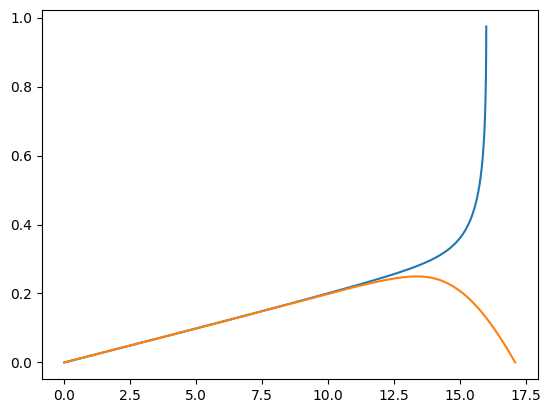

In [5]:
div_cap = max(max(outputs['P'],outputs2['P']))*1e-3
index = mylib2.find_index_array(outputs['P'],outputs2['P'],div_cap)
print('M = {M:.2f} at {A:.2f} deg'.format(M=outputs['M'][index],A=outputs['angle'][index]))
print('STAGE 1 SUCCESSFUL')
masteroutputs = {}
for i in np.arange(0,len(runparams['varnames'])):
    myname = runparams['varnames'][i]
    myvector = 0.5*(np.array(outputs[myname][0:index])+np.array(outputs2[myname][0:index]))
    masteroutputs[myname] = myvector
varnames2 = ['V','T','E','Q']

plt.plot(outputs['angle'],outputs['M'])
plt.plot(outputs2['angle'],outputs2['M'])

In [ ]:
anglemarker = [masteroutputs['angle'][-1]]

m = 0
while masteroutputs['M'][-1] < 0.99:

    time_start = time.time()
    Pmax = 1.05*masteroutputs['P'][-1]
    Pmin = 0.95*masteroutputs['P'][-1]
    n = 0
    V0 = masteroutputs['V'][-1]
    T0 = masteroutputs['T'][-1]
    xstart = masteroutputs['angle'][-1]
    Pdiff_cap = 1e-3*(Pmax-Pmin)
    while Pmax-Pmin > Pdiff_cap:
        Pmid = 0.5*(Pmax+Pmin)
        E0 = 1*(Pv0-Pmid)/(mt.sqrt(2*mt.pi*sysparams['R']*Tf0)*sysparams['m'])
        y0 = [V0,T0,0,E0]
        outputs = mylib.systemtest(y0,Pmid,xstart,sysparams,runparams)
        if outputs['status'] == 0:
            Pmin = Pmid
        elif outputs['status'] == 2:
            Pmax = Pmid
        n+=1
        #mystr = 'loop {n}, furthest theta = {s:.2f}'.format(n=n,s=outputs['angle'][-1])
        #print(mystr,end='\r',flush=True)
    
    if outputs['status'] == 2:
        Pmid = Pmin
    elif outputs['status'] == 0:
        Pmid = Pmax

    time_end = time.time()
    time_elapsed = time_end-time_start

    outputs2 = mylib.systemtest(y0,Pmid,xstart,sysparams,runparams)

    div_cap = Pdiff_cap*1e2
    index = mylib2.find_index_array(outputs['P'],outputs2['P'],div_cap)

    for i in np.arange(0,len(runparams['varnames'])):
        myname = runparams['varnames'][i]
        myvector = 0.5*(np.array(outputs[myname][0:index])+np.array(outputs2[myname][0:index]))
        masteroutputs[myname] = np.append(masteroutputs[myname],myvector)

    mystr = 'M = {M:.2f} at {d:.2f}, time elapsed = {t:.2f}'.format(M=masteroutputs['M'][-1],d=masteroutputs['angle'][-1],t=time_elapsed)
    print(mystr,end='\r',flush=True)
    m = m + 1

In [ ]:
for i in np.arange(0,len(masteroutputs)):
    locals()['d'+runparams['varnames'][i]] = masteroutputs[runparams['varnames'][i]][-1] - masteroutputs[runparams['varnames'][i]][-2]

Dtheta = 0.0001
currentM = 0
while currentM < 1:
    V0 = masteroutputs['V'][-1] + dV*Dtheta/dangle
    T0 = masteroutputs['T'][-1] + dT*Dtheta/dangle
    currentM = V0*((sysparams['Beta']/(1-sysparams['Beta']))*sysparams['Cp']*T0)**(-1/2)
    Dtheta += 0.0001

E0 = masteroutputs['E'][-1] + dE*Dtheta/dangle
Q0 = masteroutputs['Q'][-1] + dQ*Dtheta/dangle
P0 = masteroutputs['P'][-1] + dP*Dtheta/dangle
xstart = masteroutputs['angle'][-1] + Dtheta

y0 = [V0,T0,Q0,E0]
runparams['flow'] = 'transonic'
outputs = mylib.systemtest(y0,1.02*P0,xstart,sysparams,runparams)

In [ ]:
outputs_fin = {}
for i in np.arange(0,len(runparams['varnames'])):
    myname = runparams['varnames'][i]
    outputs_fin[myname] = np.append(masteroutputs[myname],outputs[myname])

foldername = runparams['run_name']
os.chdir(home+'/outputs')
if os.path.exists(foldername):
    os.chdir(foldername)
else:
    os.mkdir(foldername)
    os.chdir(foldername)

for i in np.arange(0,len(runparams['varnames'])):
    np.savetxt('{s}.txt'.format(s=runparams['varnames'][i]),outputs_fin[runparams['varnames'][i]])

In [ ]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(6,8))

myangle = np.append(masteroutputs['angle'],outputs['angle'])
myP = np.append(masteroutputs['P'],outputs['P'])
myPv = np.append(masteroutputs['Pv'],outputs['Pv'])
ax[0].plot(myangle,myP,color='black',label='local pressure')
# ax[0].plot(myangle,myP,color='black',linestyle='--',label='sat pressure')
ax[0].set_yscale('log')
# ax[0].legend()
ax[0].set_xlim(myangle[0],myangle[-1])
ax[0].set_ylabel('pressure [Pa]')

myV = np.append(masteroutputs['V'],outputs['V'])
ax[1].plot(myangle,myV,color='black')
ax[1].set_ylabel('wind speed [m/s]')

myT = np.append(masteroutputs['T'],outputs['T'])
myTf = np.append(masteroutputs['Tf'],outputs['Tf'])
ax[2].plot(myangle,myT,color='black',label='atmospheric temp')
ax[2].plot(myangle,myTf,color='black',label='surface temp',linestyle='--')
ax[2].legend()
ax[2].set_ylabel('temperature [K]')
ax[2].set_xlabel(r'$\theta$')

plt.savefig('PVT.pdf',dpi=300,bbox_inches='tight')

In [ ]:
master_time_elapsed = (time.time() - master_time_start)/60
print('total time elapsed for whole code is {s:.3f} min'.format(s=master_time_elapsed))